In [1]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from feature_extraction import graph_feature_extraction, seg_feature_extraction
from loader import hetero_graph_loader, hetero_graph_loader_faz
from utils import prep
import numpy as np
import json
import pandas as pd
from evaluation import evaluation
import copy

from itertools import product

from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle


In [2]:
# print the current path
!pwd
# change the current path
%cd ..

/home/laurin/Documents/OCTA_project/repo/OCTA_gnn/notebooks
/home/laurin/Documents/OCTA_project/repo/OCTA_gnn


/home/laurin/Documents/OCTA_project/repo/OCTA_gnn/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 2, "Early NPDR": 1, "Late NPDR": 1}
#octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 3, "Early NPDR": 1, "Late NPDR": 2}
label_names = ["Healthy/DM", "NPDR", "PDR"]
#label_names = ["Healthy/DM", "Early NPDR","Late NPDR", "PDR"]

data_type = "DCP"

vessel_graph_path = f"../data/{data_type}_vessel_graph"
label_file = "../data/labels.csv"
void_graph_path = f"../data/{data_type}_void_graph"
hetero_edges_path = f"../data/{data_type}_heter_edges"





label_file = "../data/splits"

mode_cv = "cv"
cv_pickle = f"../data/{data_type}_{mode_cv}_dataset.pkl"
cv_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = mode_cv,
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict,
                                                        pickle_file = cv_pickle
                                                        )


mode_final_test = "final_test"
final_test_pickle = f"../data/{data_type}_{mode_final_test}_dataset.pkl"
final_test_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = mode_final_test,
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict,
                                                        pickle_file = final_test_pickle
                                                        )

mode = "all"
vessel_graph_path_octa500 = f"../../OCTA_500_RELEVANT_fix/vessel_graph"
void_graph_path_octa500 = f"../../OCTA_500_RELEVANT_fix/void_graph"
hetero_edges_path_octa500 = f"../../OCTA_500_RELEVANT_fix/hetero_edges"
vessel_graph_path_octa500 = f"../../OCTA_500_RELEVANT_fix/graph_new"
label_file_octa500 = f"../../OCTA_500_RELEVANT_fix/labels_only_DR_Healthy.csv"

octa_500_dict = {"NORMAL": 0, "DR": 1}
label_names_OCTA500 = ["NORMAL", "DR"]

octa500_pickle = f"../../OCTA_500_RELEVANT_fix/OCTA500_{data_type}_{mode}_dataset_no_faz.pkl"
octa500_data = hetero_graph_loader.HeteroGraphLoaderTorch(graph_path_1=vessel_graph_path_octa500,
                                                        graph_path_2=void_graph_path_octa500,
                                                        hetero_edges_path_12=hetero_edges_path_octa500,
                                                        mode = mode,
                                                        label_file = label_file_octa500, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_500_dict,
                                                        pickle_file = octa500_pickle #f"../{data_type}_{mode_train}_dataset_faz.pkl" # f"../{data_type}_{mode_train}_dataset_faz.pkl"
                                                        )



num_classes = len(np.unique(list(octa_dr_dict.values())))

In [4]:

def aggreate_graph(dataset, features_label_dict, faz = False):
    # check if the datasets have an faz node type
    node_types = ["graph_1", "graph_2"]

    if faz:
        node_types.append("faz")
        x_1_shape = len(features_label_dict["graph_2"]) *2 + len(features_label_dict["graph_1"])
    else:
        x_1_shape = len(features_label_dict["graph_2"]) + len(features_label_dict["graph_1"])

    x_0_shape = len(dataset)
    x = np.zeros((x_0_shape, x_1_shape))
    y = np.zeros((x_0_shape,))

    for i in range(len(dataset)):
        graph_1 = dataset[i]["graph_1"]
        graph_2 = dataset[i]["graph_2"]
        y[i] = dataset[i].y
        
        # average the features of all nodes in the graph 
        graph_1_sum = graph_1.x.numpy().sum(axis = 0)
        graph_2_sum = graph_2.x.numpy().sum(axis = 0)

        x[i,:len(features_label_dict["graph_1"])] = graph_1_sum
        x[i,len(features_label_dict["graph_1"]):] = graph_2_sum

        if "faz" in node_types:
            print("FAZ is in the node types")
            faz = dataset[i]["faz"]
            faz_sum = faz.x.numpy().sum(axis = 0)
            x[i,len(features_label_dict["graph_1"])+len(features_label_dict["graph_2"]):] = faz_sum

    return x, y


def hyper_param_search(grid, classifier, x_train, y_train, x_val, y_val):
    best_score = 0
    best_params = None
    for param_set in product(*grid.values()):
        params = dict(zip(grid.keys(), param_set))
        clf = classifier(**params, random_state=42)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_val)
        score = balanced_accuracy_score(y_val, y_pred)
        #score = cohen_kappa_score(y_val, y_pred, weights="quadratic") 
        if score > best_score:
            best_score = score
            best_params = params
            best_clf = clf

    y_pred = best_clf.predict(x_val)

    final_accuracy = accuracy_score(y_val, y_pred)
    final_balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
    final_kappa = cohen_kappa_score(y_val, y_pred, weights="quadratic") # , weights="quadratic"

    print(f"Validation Accuracy: {final_accuracy}")
    print(f"Validation Balanced Accuracy: {final_balanced_accuracy}")
    print(f"Validation Kappa: {final_kappa}")
    # return the best classifier
    return best_params, best_score, best_clf

def evaluation_pipeline(model, x, y, label_names, title = None):
    y_pred = model.predict(x)
    y_prob = model.predict_proba(x)
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    evaluation.plot_confusion_matrix(y, y_pred, label_names, ax[0]) #, ["Healthy/DM","PDR", "NPDR"]"Early NPDR", "Late NPDR" , 3, 4 # ["Healthy/DM", "PDR", "NPDR"]
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])

    label_binarizer = LabelBinarizer().fit(y)
    y_onehot = label_binarizer.transform(y)


    if num_classes == 2:
        RocCurveDisplay.from_predictions(
            y,
            y_prob[:, 1],
            name="ROC curve",
            ax=ax[1],
            color="red",
        )
    else:
        for class_id, color in zip(range(num_classes), colors):
            RocCurveDisplay.from_predictions(
                y_onehot[:, class_id],
                y_prob[:, class_id],
                name=f"{class_id} vs the rest",
                color=color,
                ax=ax[1],
                plot_chance_level=(class_id == 2),
            )
    # add title
    if title is not None:
        fig.suptitle(title)
    plt.show()

    if num_classes == 2:
        mean_auc = roc_auc_score(
            y_true=y,
            y_score = y_prob[:,1],
            multi_class="ovo",
            average="macro",
        )
    else:
        mean_auc = roc_auc_score(
            y_true=y,
            y_score = y_prob,
            multi_class="ovo",
            average="macro",
        )

    # print metrics
    print(classification_report(y, y_pred, target_names=label_names))

    print(f"Accuracy Score: {accuracy_score(y, y_pred)}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(y, y_pred)}")
    print(f"Mean AUC: {mean_auc}")
    print(f"Cohen Kappa Score (quadratic weights): {cohen_kappa_score(y, y_pred, weights='quadratic')}")



def eliminiate_features(train_dataset, test_dataset, val_dataset):
    # read the feature_name_dict.json
    import torch
    with open("feature_name_dict.json", "r") as file:
        label_dict_full = json.load(file)
        #features_label_dict = json.load(file)
    features_label_dict = copy.deepcopy(label_dict_full)

    eliminate_features = {"graph_1":["hasNodeAtSampleBorder", "maxRadiusStd", "avgRadiusStd", "hetero_degree"], 
                          "graph_2":["centroid_weighted-0", "centroid_weighted-1","orientation","solidity", "intensity_max", "intensity_mean", "intensity_min"]} # "feret_diameter_max", "equivalent_diameter",  #"centroid_weighted-0", "centroid_weighted-1", 
#
    for key in eliminate_features.keys():
        for feat in eliminate_features[key]:
            idx = features_label_dict[key].index(feat)
            features_label_dict[key].remove(feat)
            for data in train_dataset:
                data[key].x = torch.cat([data[key].x[:, :idx], data[key].x[:, idx+1:]], dim = 1)
            for data in test_dataset:
                data[key].x = torch.cat([data[key].x[:, :idx], data[key].x[:, idx+1:]], dim = 1)
            for data in val_dataset:
                data[key].x = torch.cat([data[key].x[:, :idx], data[key].x[:, idx+1:]], dim = 1)



    return train_dataset, test_dataset, val_dataset, features_label_dict

def plot_feature_importances(clf, features_label_dict):
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

    forest_importances = pd.Series(importances)

    fig, ax = plt.subplots(figsize=(18, 8))

    forest_importances.plot.bar(yerr=std, ax=ax)
    # add feature names as x-axis labels, avoid overwriting
    feature_names = features_label_dict["graph_1"] + features_label_dict["graph_2"] #+ features_label_dict["graph_2"] + ["y_label"]
    ax.set_xticklabels(feature_names) # , rotation=90
    ax.set_title("Feature importances using MDI")
    ax.set_xlabel("Mean decrease in impurity")
    fig.tight_layout()

    # last features are the segmentation features
    plt.show()



from multiprocessing import Pool, Manager


def worker(args):
    params, classifier, x_train, y_train, x_val, y_val, best_score, best_params, best_clf = args
    clf = classifier(**params, random_state=42)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_val)
    score = balanced_accuracy_score(y_val, y_pred)
    if score > best_score.value:
        best_score.value = score
        best_params.update(params)
        best_clf.append(clf)
    return

def hyper_param_search_multi(grid, classifier, x_train, y_train, x_val, y_val):
    with Manager() as manager:
        best_score = manager.Value('d', 0)
        best_params = manager.dict()
        best_clf = manager.list()
        with Pool() as pool:
            pool.map(worker, [(dict(zip(grid.keys(), param_set)), classifier, x_train, y_train, x_val, y_val, best_score, best_params, best_clf) for param_set in product(*grid.values())])

        y_pred = best_clf[0].predict(x_val)

        final_accuracy = accuracy_score(y_val, y_pred)
        final_balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
        final_kappa = cohen_kappa_score(y_val, y_pred, weights="quadratic")

        print(f"Validation Accuracy: {final_accuracy}")
        print(f"Validation Balanced Accuracy: {final_balanced_accuracy}")
        print(f"Validation Kappa: {final_kappa}")
        # return the best classifier
        return dict(best_params), best_score.value, best_clf[0]

Split 1
train dataset: 845
val dataset: 211
test dataset: 211
Validation Accuracy: 0.7582938388625592
Validation Balanced Accuracy: 0.6618578422259405
Validation Kappa: 0.5805632247377139


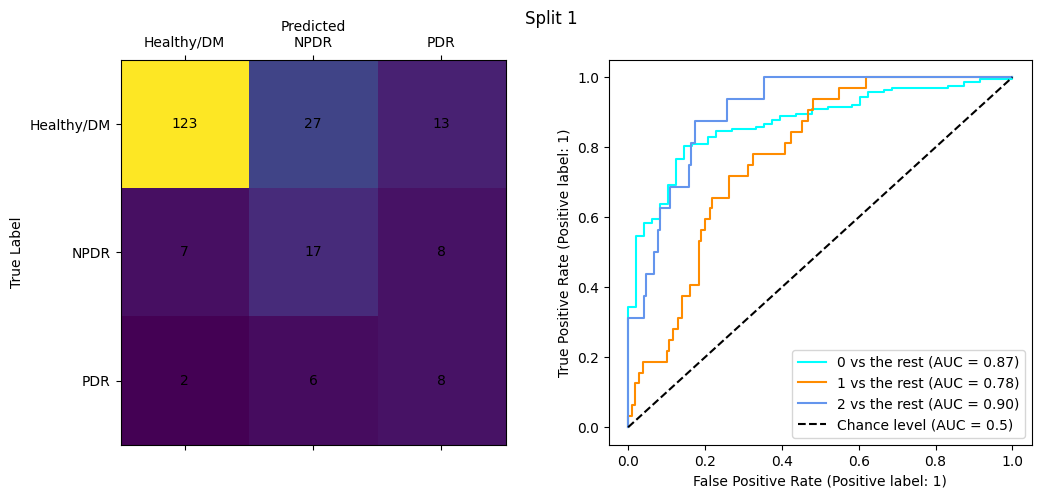

              precision    recall  f1-score   support

  Healthy/DM       0.93      0.75      0.83       163
        NPDR       0.34      0.53      0.41        32
         PDR       0.28      0.50      0.36        16

    accuracy                           0.70       211
   macro avg       0.52      0.60      0.53       211
weighted avg       0.79      0.70      0.73       211

Accuracy Score: 0.7014218009478673
Balanced Accuracy Score: 0.5952837423312883
Mean AUC: 0.7675661426380368
Cohen Kappa Score (quadratic weights): 0.4503352790776207
Split 2
train dataset: 845
val dataset: 211
test dataset: 211
Validation Accuracy: 0.7203791469194313
Validation Balanced Accuracy: 0.5199386503067485
Validation Kappa: 0.5120354385850624


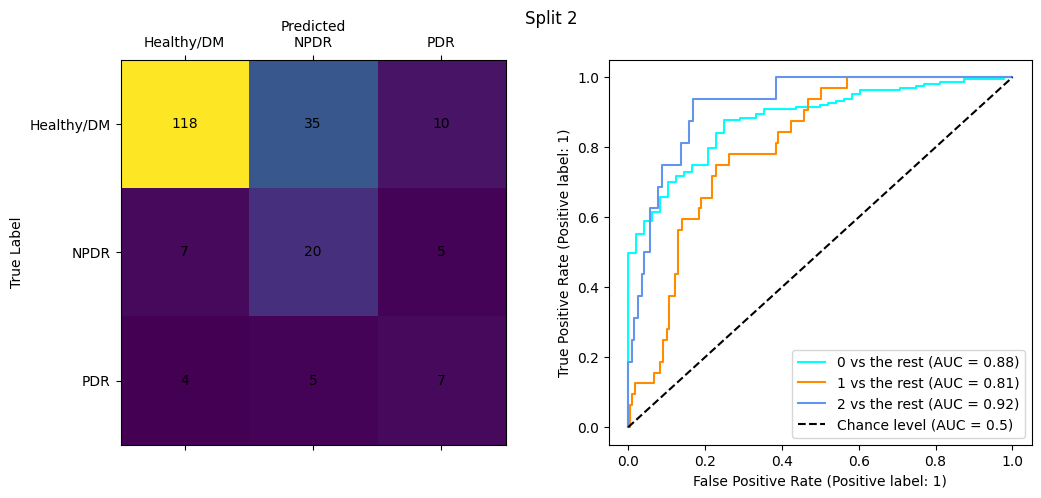

              precision    recall  f1-score   support

  Healthy/DM       0.91      0.72      0.81       163
        NPDR       0.33      0.62      0.43        32
         PDR       0.32      0.44      0.37        16

    accuracy                           0.69       211
   macro avg       0.52      0.60      0.54       211
weighted avg       0.78      0.69      0.72       211

Accuracy Score: 0.6872037914691943
Balanced Accuracy Score: 0.5954754601226994
Mean AUC: 0.7932463413854806
Cohen Kappa Score (quadratic weights): 0.40301791889342986
Split 3
train dataset: 844
val dataset: 212
test dataset: 211
Validation Accuracy: 0.7216981132075472
Validation Balanced Accuracy: 0.6500369549150037
Validation Kappa: 0.517304189435337


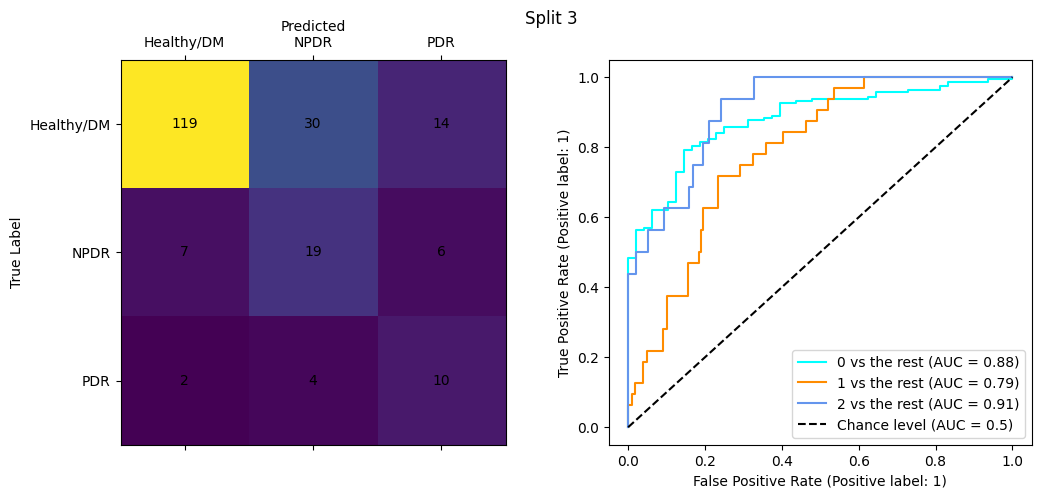

              precision    recall  f1-score   support

  Healthy/DM       0.93      0.73      0.82       163
        NPDR       0.36      0.59      0.45        32
         PDR       0.33      0.62      0.43        16

    accuracy                           0.70       211
   macro avg       0.54      0.65      0.57       211
weighted avg       0.80      0.70      0.73       211

Accuracy Score: 0.7014218009478673
Balanced Accuracy Score: 0.6496037832310838
Mean AUC: 0.7793408103271983
Cohen Kappa Score (quadratic weights): 0.4462466012531032
Split 4
train dataset: 844
val dataset: 212
test dataset: 211
Validation Accuracy: 0.7783018867924528
Validation Balanced Accuracy: 0.621424275231565
Validation Kappa: 0.64215095249578


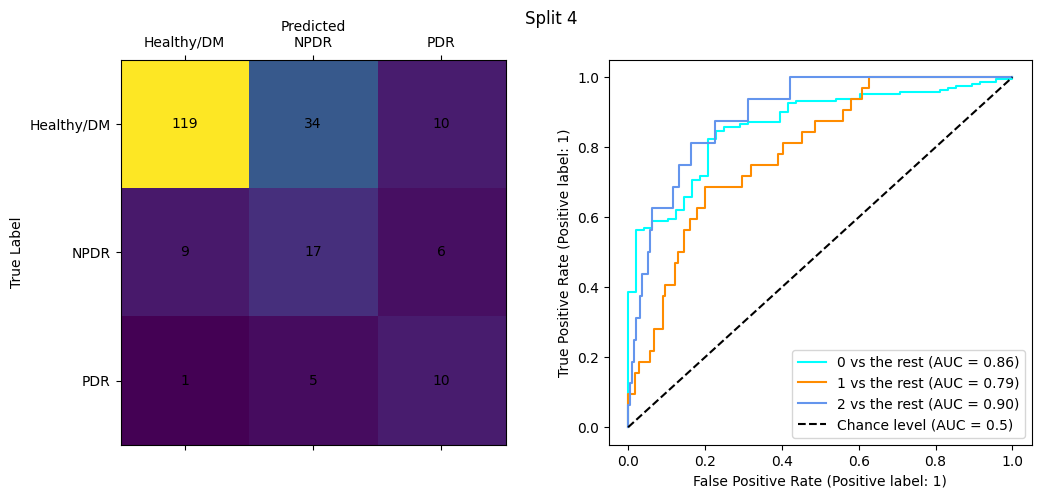

              precision    recall  f1-score   support

  Healthy/DM       0.92      0.73      0.82       163
        NPDR       0.30      0.53      0.39        32
         PDR       0.38      0.62      0.48        16

    accuracy                           0.69       211
   macro avg       0.54      0.63      0.56       211
weighted avg       0.79      0.69      0.72       211

Accuracy Score: 0.6919431279620853
Balanced Accuracy Score: 0.6287704498977505
Mean AUC: 0.7815375766871165
Cohen Kappa Score (quadratic weights): 0.48551950636942676
Split 5
train dataset: 846
val dataset: 210
test dataset: 211
Validation Accuracy: 0.8047619047619048
Validation Balanced Accuracy: 0.6074812542603953
Validation Kappa: 0.5973688867913397


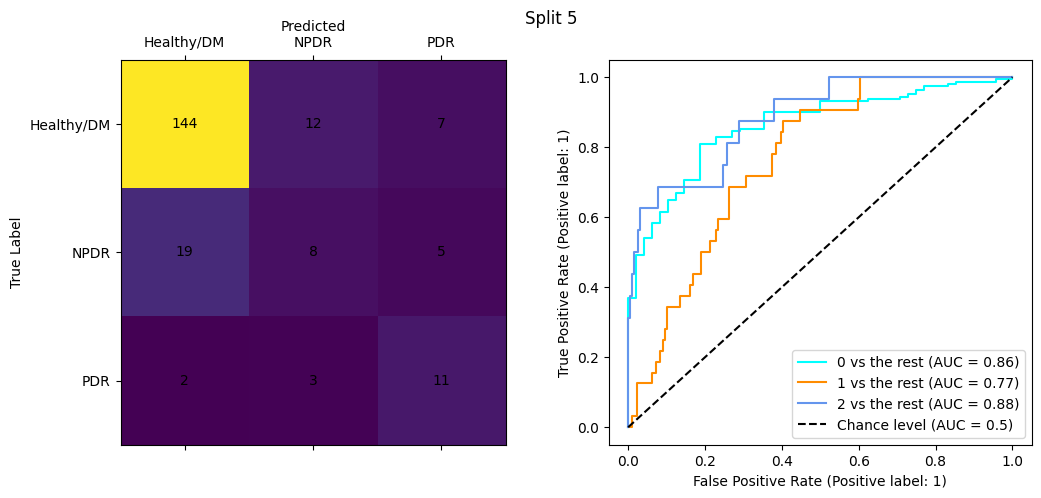

              precision    recall  f1-score   support

  Healthy/DM       0.87      0.88      0.88       163
        NPDR       0.35      0.25      0.29        32
         PDR       0.48      0.69      0.56        16

    accuracy                           0.77       211
   macro avg       0.57      0.61      0.58       211
weighted avg       0.76      0.77      0.77       211

Accuracy Score: 0.7725118483412322
Balanced Accuracy Score: 0.6069785276073619
Mean AUC: 0.7578144970603272
Cohen Kappa Score (quadratic weights): 0.5565860629325563


In [5]:
#param_grid = {'max_depth': [4, 5, 6, 8], 'max_features': ["sqrt", "log2"], 'class_weight': ['balanced','balanced_subsample', None], 'n_estimators': [100,  300]} 
#classifier = RandomForestClassifier

param_grid = {'C' : [0.1, 1], 'gamma' : [0.1, 1], 'kernel' : ["rbf", "linear"] , 'probability' : [True], 'class_weight': ['balanced', None]} #SVC #, "poly", "sigmoid"
classifier = SVC

with open("feature_name_dict.json", "r") as file:
    label_dict_full = json.load(file)
    #features_label_dict = json.load(file)
features_label_dict = copy.deepcopy(label_dict_full)


best_param_dict = {}
best_score_dict = {}
clf_dict = {}

for split in [1,2,3,4,5]: #,2,3,4,5]
    print(f"Split {split}")

    train_dataset, val_dataset, test_dataset = prep.adjust_data_for_split(cv_dataset, final_test_dataset, split)

    #train_dataset, test_dataset, val_dataset, features_label_dict = eliminiate_features(train_dataset, test_dataset, val_dataset)

    train_dataset_work = copy.deepcopy(train_dataset.hetero_graph_list)
    val_dataset_work = copy.deepcopy(val_dataset.hetero_graph_list)
    test_dataset_work = copy.deepcopy(test_dataset.hetero_graph_list)

    x_train, y_train = aggreate_graph(train_dataset_work, features_label_dict)
    x_val, y_val = aggreate_graph(val_dataset_work, features_label_dict)
    x_test, y_test = aggreate_graph(test_dataset_work, features_label_dict)

    best_params, best_score, clf = hyper_param_search(param_grid, classifier, x_train, y_train, x_val, y_val)
    best_param_dict[split] = best_params
    best_score_dict[split] = best_score
    clf_dict[split] = clf

    evaluation_pipeline(clf, x_test, y_test, label_names, title = f"Split {split}")


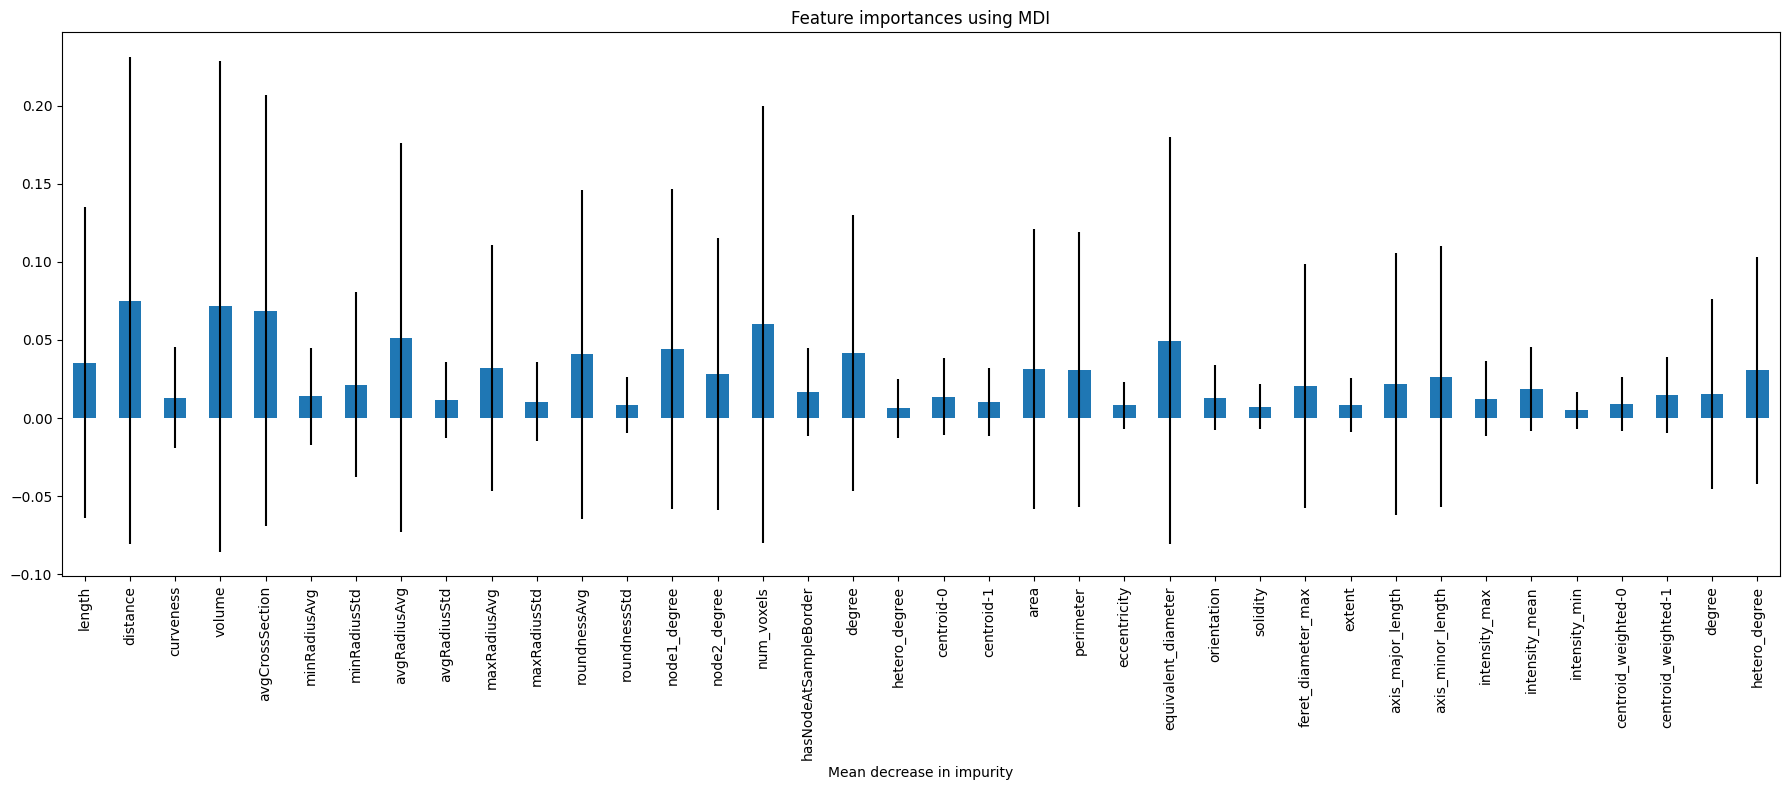

In [15]:
plot_feature_importances(clf, features_label_dict)

In [6]:
# with each classifier stored in clf_dict, predict the final test set

df_report = pd.DataFrame()
df_metrics = pd.DataFrame()
df_best_params = pd.DataFrame()

for clf_name, clf in clf_dict.items():
    y_pred = clf.predict(x_test)
    y_prob = clf.predict_proba(x_test)

    if num_classes == 2:
        mean_auc = roc_auc_score(
            y_true=y_test,
            y_score = y_prob[:,1],
            multi_class="ovo",
            average="macro",
        )
    else:
        mean_auc = roc_auc_score(
            y_true=y_test,
            y_score = y_prob,
            multi_class="ovo",
            average="macro",
        )
    report = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)

    acc= accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred, weights="quadratic")

    metrics = {}

    metrics["accuracy"] = acc
    metrics["balanced_accuracy"] = bal_acc
    metrics["kappa"] = kappa
    metrics["mean_auc"] = mean_auc

    df_metrics = pd.concat([df_metrics, pd.DataFrame(metrics, index = [clf_name])])

    df_report = pd.concat([df_report, pd.DataFrame(report).transpose()])
    df_best_params = pd.concat([df_best_params, pd.DataFrame(best_param_dict[clf_name], index = [clf_name])])


    #results_report[clf_name] = report


print(df_metrics)
print(df_report)
print(df_best_params)

#df_metrics.to_csv('RF_CV_metrics_3class_all_feat_mean.csv')
#df_report.to_csv('RF_CV_report_3class_all_feat_mean.csv')
#df_best_params.to_csv('RF_CV_best_params_3class_all_feat_mean.csv')




   accuracy  balanced_accuracy     kappa  mean_auc
1  0.715640           0.620207  0.486103  0.761863
2  0.668246           0.606084  0.396168  0.788194
3  0.696682           0.639187  0.440159  0.777252
4  0.691943           0.628770  0.459694  0.776982
5  0.772512           0.606979  0.556586  0.757814
              precision    recall  f1-score     support
Healthy/DM     0.939850  0.766871  0.844595  163.000000
NPDR           0.354167  0.531250  0.425000   32.000000
PDR            0.300000  0.562500  0.391304   16.000000
accuracy       0.715640  0.715640  0.715640    0.715640
macro avg      0.531339  0.620207  0.553633  211.000000
weighted avg   0.802506  0.715640  0.746587  211.000000
Healthy/DM     0.918699  0.693252  0.790210  163.000000
NPDR           0.317460  0.625000  0.421053   32.000000
PDR            0.320000  0.500000  0.390244   16.000000
accuracy       0.668246  0.668246  0.668246    0.668246
macro avg      0.518720  0.606084  0.533835  211.000000
weighted avg   0.78211

In [9]:
# prepare the OCTA 500 data
_, _, octa500test_dataset_work = prep.adjust_data_for_split(cv_dataset, octa500_data, 3)
x_test_octa500, y_test_octa500 = aggreate_graph(octa500test_dataset_work, features_label_dict)

train dataset: 844
val dataset: 212
test dataset: 189


In [7]:
# pickle save the best classifiers stored in clf_dict, with the split number in the filename
import pickle
for clf_name, clf in clf_dict.items():
    with open(f"best_clf_svm_sumAGG_allFeatures_{clf_name}.pkl", "wb") as file:
        pickle.dump(clf, file)


In [10]:
# with each classifier stored in clf_dict, predict the final test set

df_report = pd.DataFrame()
df_metrics = pd.DataFrame()
df_best_params = pd.DataFrame()

for clf_name, clf in clf_dict.items():
    y_pred = clf.predict(x_test_octa500)

    y_pred[y_pred>1]=1
    # y_prob only has 2 columns, so we need to binarize it
    # we keep the probabilities for the first class and take the max of the second and third class
    
    report = classification_report(y_test_octa500, y_pred, target_names=label_names_OCTA500, output_dict=True)
    acc= accuracy_score(y_test_octa500, y_pred)
    bal_acc = balanced_accuracy_score(y_test_octa500, y_pred)
    kappa = cohen_kappa_score(y_test_octa500, y_pred, weights="quadratic")

    metrics = {}

    metrics["accuracy"] = acc
    metrics["balanced_accuracy"] = bal_acc
    metrics["kappa"] = kappa


    df_metrics = pd.concat([df_metrics, pd.DataFrame(metrics, index = [clf_name])])

    df_report = pd.concat([df_report, pd.DataFrame(report).transpose()])
    df_best_params = pd.concat([df_best_params, pd.DataFrame(best_param_dict[clf_name], index = [clf_name])])


    #results_report[clf_name] = report


print(df_metrics)
print(df_report)
print(df_best_params)

#df_metrics.to_csv('RF_CV_metrics_3class_all_feat_mean.csv')
#df_report.to_csv('RF_CV_report_3class_all_feat_mean.csv')
#df_best_params.to_csv('RF_CV_best_params_3class_all_feat_mean.csv')




   accuracy  balanced_accuracy     kappa
1  0.153439           0.500000  0.000000
2  0.349206           0.573276  0.055269
3  0.153439           0.500000  0.000000
4  0.285714           0.564009  0.044489
5  0.835979           0.874892  0.542873
              precision    recall  f1-score     support
NORMAL         0.000000  0.000000  0.000000  160.000000
DR             0.153439  1.000000  0.266055   29.000000
accuracy       0.153439  0.153439  0.153439    0.153439
macro avg      0.076720  0.500000  0.133028  189.000000
weighted avg   0.023544  0.153439  0.040823  189.000000
NORMAL         0.930233  0.250000  0.394089  160.000000
DR             0.178082  0.896552  0.297143   29.000000
accuracy       0.349206  0.349206  0.349206    0.349206
macro avg      0.554157  0.573276  0.345616  189.000000
weighted avg   0.814823  0.349206  0.379213  189.000000
NORMAL         0.000000  0.000000  0.000000  160.000000
DR             0.153439  1.000000  0.266055   29.000000
accuracy       0.153439  0

/home/laurin/Documents/OCTA_project/repo/OCTA_gnn/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/laurin/Documents/OCTA_project/repo/OCTA_gnn/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/laurin/Documents/OCTA_project/repo/OCTA_gnn/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control